# Interactive Parallax / Proper Motion Animation

This notebook uses widgets to illustrate parallax and proper motion.

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, FloatSlider, Layout

In [2]:
# High-level parameters
SIZE = 256     # number of points in each line
DEC = 45.      # degrees, declination of star
DIST = 10      # parsecs, distance to star
VPROP_RA = 0   # mas / yr, proper motion in ra direction
VPROP_DEC = 0  # mas / yr, proper motion in dec direction
NSTEPS = 300   # number of cycles in simulation before repeat
STEP = NSTEPS / 60            # fraction of a year per step
TAIL = 100                    # number of data points to tail
VIEW = 10                     # mas to view

# Constants
AU = 1.5e13               # cm, astronomical unit
PC = 3e18                 # cm, parsec
mas = 1 / (60 * 60 * 1e3) # degrees, milliarcsecond

# Variables derived from parameters above
pos = (np.zeros(TAIL), np.zeros(TAIL))

def update_star(t, dec0, dist, vra, vdec):
    """Launch photon wavelets along each line, propagating radially outward 
    at one index per simulation cycle."""
    pos[0][:-1] = pos[0][1:] #  propagate
    pos[1][:-1] = pos[1][1:] #  propagate
    dra_max = np.arctan2(AU, dist * PC)
    ddec_max = np.arctan2(AU * np.sin(dec0), dist * PC)
    pos[0][-1] =  vra * t +  dra_max * np.cos(2 * np.pi * STEP * t)
    pos[1][-1] = vdec * t + ddec_max * np.sin(2 * np.pi * STEP * t)

interactive(children=(FloatSlider(value=45.0, description='Star Declination [degrees]', layout=Layout(grid_are…

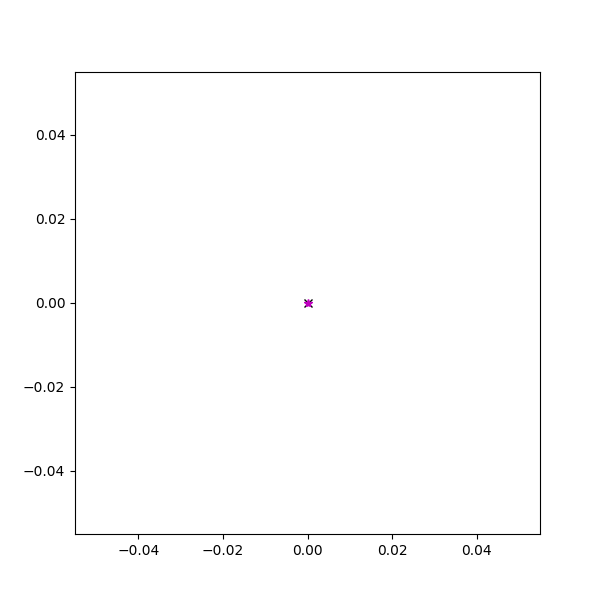

In [3]:
# Generate the animation figure

fig, (ax1) = plt.subplots(figsize=(6,6))
srcpos_J2000, = ax1.plot([0], [0], 'kx')  # plot catalog source position
srcpos_cur, = ax1.plot(pos[0][-1:], pos[1][-1:], 'm*')
srctrack, = ax1.plot(pos[0], pos[1], 'k') # holds handle for incoming radiation

# Sliders controlling animation
dec_widget = FloatSlider(DEC, min=0, max=90, step=0.01,
                           description='Star Declination [degrees]',
                           style={'description_width':'initial'},
                           layout=Layout(width='auto', grid_area='footer'))
dist_widget = FloatSlider(DIST, min=0, max=20.0, step=0.5,
                           description='Star Distance [pc]',
                           style={'description_width':'initial'},
                           layout=Layout(width='auto', grid_area='footer'))
vra_widget  = FloatSlider(VPROP_RA, min=-10.0, max=10.0, step=0.1,
                           description='Star RA velocity [mas/yr]',
                           style={'description_width':'initial'},
                           layout=Layout(width='auto', grid_area='footer'))
vdec_widget = FloatSlider(VPROP_DEC, min=-10.0, max=10.0, step=0.1,
                           description='Star DEC velocity [mas/yr]',
                           style={'description_width':'initial'},
                           layout=Layout(width='auto', grid_area='footer'))

def animate(t):
    '''Update plots for each line according to the time step. Reads dec, dist,
    vra, and vdec from widgets. Called repeatedly by FuncAnimation.'''
    dec0 = dec_widget.value
    dist = dist_widget.value
    vra = vra_widget.value * mas
    vdec = vdec_widget.value * mas
    update_star(t, dec0, dist, vra, vdec)
    srctrack.set_xdata(pos[0] / mas)
    srctrack.set_ydata(pos[1] / mas)
    srcpos_cur.set_xdata(pos[0][-1:] / mas)
    srcpos_cur.set_ydata(pos[1][-1:] / mas)
    
    
def init():
    '''Set initial plot parameters. Called once by FuncAnimation at beginning.'''
    ax1.set_xlim(-VIEW, VIEW) # ra
    ax1.set_ylim(-VIEW, VIEW) # dec
    ax1.set_xlabel('$\Delta$RA [mas]')
    ax1.set_ylabel('$\Delta$DEC [mas]')
    ax1.set_title('Parallax and Proper Motion')
    ax1.grid(True)
    
steps = np.linspace(0, 1, NSTEPS) # simulation interval
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=50, blit=True)

def build_animation(dec, dist, vra, vdec):
    '''Function which causes FuncAnimation to redraw itself when input widgets change.
    Does not actually hand off the value, but needs to accept widget arguments to
    be triggered by updating the slider.'''
    ani.new_frame_seq()

# force animation to redraw when freq_widget changes, even though
# the parameter is not actually passed through (used as global, instead)
interact(build_animation, dec=dec_widget, dist=dist_widget, vra=vra_widget, vdec=vdec_widget)
plt.show()